### ODI Cricket Matches Analysis

In [1]:
#Importing useful libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load Data

matches = pd.read_csv("data/Men ODI Team Match Results - 21st Century.csv")
matches.head(2)

,Result,Margin,Match,Home/Away,Ground,Match Date,Match Month,Match Year,Match Period,Matches,Country
0,Lost,5 wickets,Sri Lanka v England,Away,Dambulla,2001/03/23,Mar,2001,Mar 2001,1,England
1,Lost,66 runs,Sri Lanka v England,Away,Colombo (RPS),2001/03/25,Mar,2001,Mar 2001,1,England


In [3]:
# Shape and Datatypes

matches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5170 entries, 0 to 5169
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Result        5170 non-null   object
 1   Margin        5163 non-null   object
 2   Match         5170 non-null   object
 3   Home/Away     5170 non-null   object
 4   Ground        5170 non-null   object
 5   Match Date    5170 non-null   object
 6   Match Month   5170 non-null   object
 7   Match Year    5170 non-null   int64 
 8   Match Period  5170 non-null   object
 9   Matches       5170 non-null   int64 
 10  Country       5170 non-null   object
dtypes: int64(2), object(9)
memory usage: 444.4+ KB


In [4]:
# Missing Values

missing = matches.isna().sum()
print(f"Dataset has {missing} missing values")

Dataset has Result          0
Margin          7
Match           0
Home/Away       0
Ground          0
Match Date      0
Match Month     0
Match Year      0
Match Period    0
Matches         0
Country         0
dtype: int64 missing values


In [5]:
# Removing missing values as there are only 7 values missing

matches = matches[~matches['Margin'].isna()]

### Exploratory Data Analysis

###### What is the distribution of match results (Win/Loss/Tied/NR) in the dataset?

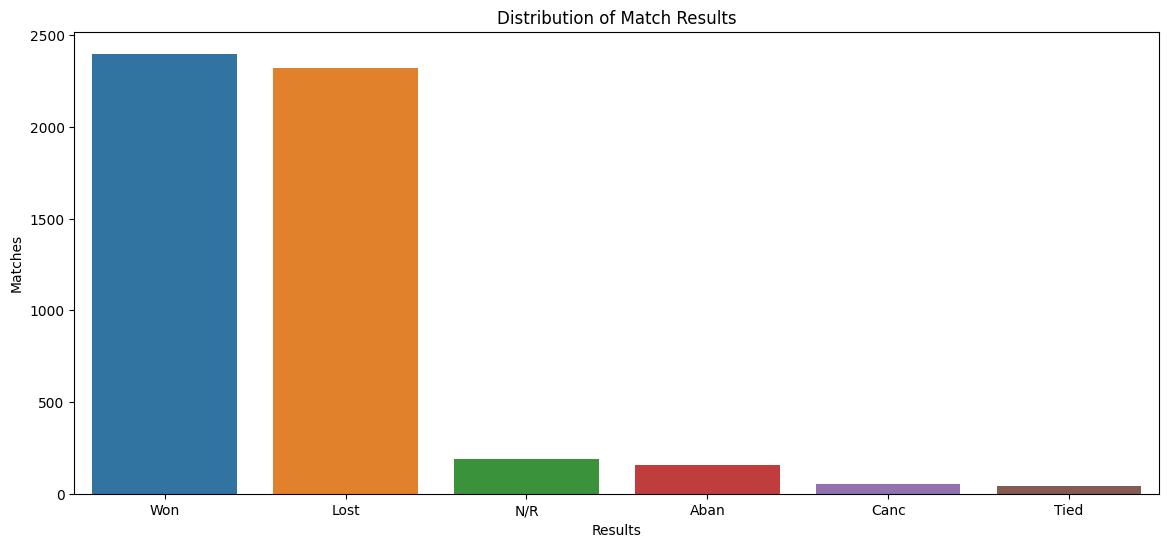

In [6]:
results = matches['Result'].value_counts().reset_index(name="matches")

plt.figure(figsize=(14,6))
sns.barplot(x='Result',y='matches',data=results)
plt.title("Distribution of Match Results")
plt.xlabel("Results")
plt.ylabel("Matches")
plt.show()

In [17]:
win_loss = matches[(matches['Result']=='Lost') | (matches['Result']=='Won')]
win_loss.shape

(4719, 13)

###### Find any patterns in margins of victory/defeat? Are Easy wins more common than close matches?